# Experimentovanie a vyhodnocovanie

Bc. Miroslav Čulík a Bc. Andrej Gáfrik

Otázky:
- MSE vs R2 - ak odstránime z input df inštancie s cenou viac ako threshold (815000), vieme znižiť MSE, RMSE ale spadne nam aj R2 - ktora metrika by mala byť prioritná
- primitívny prediktor - pred všetky inštancie budeme predikovať priemernú cenu a porovnáme MSE, RMSE, R2,...
- môžu sa odstraňovať outlieri po transformácii? nemali by sme nahrádzať hodnoty outlierov takými, akými sme ich identifikovali?
- RandomSearch pri RF: Ktorý model je lepší - ten čo má nižšiu delta_R2 alebo ten čo má najvyšší R2_test?

TODOs:
- prekopčiť veci z minulých správ do finálnej správy na overleafe https://www.overleaf.com/project/5e7101e344e1ac0001e3041b
- Experimenty
    - DM metóda: experimentovanie, nastavenie parametrov, trénovanie, testovanie, ...
    - vyhodnotenie: vyhodnotenie výsledkov, porovnanie metód (aj s publikovanými prácami)
- Zhrnutie
    - zhodnotenie toho, čo sa v rámci projektu podarilo
    - náčrt ďalšieho vhodného smerovania projektu
- Literatúra: zoznam použitej literatúry a ich citovanie v správe


- ~~pridat nove modely~~
    - ~~RF~~
    - ~~SVR~~

- ~~hyperparameter tuning~~
    - ~~manual pri RF~~
    - ~~gridsearch~~
    - ~~random search na RF a podla neho gridsearch~~
- ~~primitívny prediktor~~
- ~~refactoring~~
- feature importance(RF, Decision Tree)
- upravit pipeline pre data mensie ako threshold, ktory je r_whisker
- optional: skusit ako to bude ked dame namiesto boxcox pri cene log transformaciu


In [2]:
cd ..

C:\Users\Andrej\Desktop\OZNAL\oznal_project


In [3]:
import seaborn as sns
import random
import itertools
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.special import inv_boxcox
from matplotlib import pyplot as plt
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from numpy.polynomial.polynomial import polyfit

from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import SGDRegressor

from src import analysis, preprocessing2, feature_selection2, metrics2, tuning3

pd.set_option('max_rows', None)
pd.set_option('max_columns', None)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [4]:
path_housing = "data\\kc_house_data.csv"
df = pd.read_csv(path_housing, sep=",")
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.00000,3,1.00000,1180,5650,1.00000,0,0,3,7,1180,0,1955,0,98178,47.51120,-122.25700,1340,5650
1,6414100192,20141209T000000,538000.00000,3,2.25000,2570,7242,2.00000,0,0,3,7,2170,400,1951,1991,98125,47.72100,-122.31900,1690,7639
2,5631500400,20150225T000000,180000.00000,2,1.00000,770,10000,1.00000,0,0,3,6,770,0,1933,0,98028,47.73790,-122.23300,2720,8062
3,2487200875,20141209T000000,604000.00000,4,3.00000,1960,5000,1.00000,0,0,5,7,1050,910,1965,0,98136,47.52080,-122.39300,1360,5000
4,1954400510,20150218T000000,510000.00000,3,2.00000,1680,8080,1.00000,0,0,3,8,1680,0,1987,0,98074,47.61680,-122.04500,1800,7503


Po konzultácii sme sa rozhodli vyfiltrovať dáta od určenej hranice. Uvažovali sme o dvoch hraničných hodnotách. Lepšie výsledky sme dosiahli s hraničnou hodnotou 815,000.

In [5]:
# _,threshold = analysis.get_whiskers(df["price"])
threshold = 815000
new_df = df[df["price"]<=threshold]
print(len(new_df))

18814


Predspracovanie dát s použitím našej vlastnej pipeline.

In [6]:
X_train, X_valid, X_test, y_train, y_valid, y_test, price_lambda = preprocessing2.run_pipeline(new_df)

C:\Users\Andrej\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [7]:
X_train.head()

,id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode_1,zipcode_2,zipcode_3,zipcode_4,zipcode_5,zipcode_6,zipcode_7,lat,long,sqft_living15,sqft_lot15,recon_age,price_per_sqft
13648,5072200040,3,2.00000,23.95147,4.55927,1.00000,0,2,5,8,4.32004,17.60682,1957,0,0,0,0,0,0,0,1,47.44190,-122.34000,7.58070,4.29089,57,0.19517
11891,7305300695,4,2.50000,26.72466,4.47489,2.00000,0,0,3,9,4.47520,0.00000,2014,0,0,0,0,0,0,1,0,47.75380,-122.32500,7.17012,4.25315,0,0.23530
20602,7853361370,4,2.50000,28.03220,4.42275,2.00000,0,0,3,8,4.51903,0.00000,2012,0,0,0,0,0,0,1,1,47.51500,-121.87000,7.77486,4.15893,2,0.19197
5956,3328500250,4,2.50000,24.80360,4.49669,2.00000,0,0,3,8,4.40499,0.00000,1987,0,0,0,0,0,1,0,0,47.34060,-122.26900,7.74500,4.26807,27,0.19080
11907,3221059036,4,2.50000,28.81062,4.45155,1.50000,0,0,3,9,4.41777,36.46917,1979,0,0,0,0,0,1,0,1,47.26170,-122.19000,7.94803,4.23324,35,0.17372


## Experimenty

Po predspracovaní dát nami vytvorenou pipeline, sme mali dáta rozdelené v pomere 70:20:10 (trénovacia : validačná : testovacia množina). Použili sme implementácie algoritmov z modulu sklearn. Najlepšie výsledky podľa metriky R$^2$ dosiahol model polynomiálnej regresie 3. stupňa s použitím selekcie čŕt RFE (0.901 na trénovacej a 0.76 na testovacej množine), druhý najlepší výsledok podľa tejto metriky dosiahol model regresného rozhodovacieho stromu(0.876 na trénovacej a 0.715 na testovacej množine). Porovnateľné výsledky boli dosiahnuté aj s použitím náhodného lesu. V prípade modelu jednoduchej lineárnej regresie sme vyskúšali aj 5, resp. 10 - násobnú krížovú validáciu, na porovnanie výsledkov s modelom jednoduchej lineárnej regresie trénovaného tradičným spôsobom, avšak tento prístup nám nepreukázal žiaden signifikantný rozdiel vo výsledkoch pri modeloch jednoduchej lineárnej regresie.
 

### Primitívny prediktor
Náš primitívny prediktor bude slúžiť na porovnanie s našimi modelmi pri metrikách MSE, RMSE a RMSLE. Predikovať budeme pre každú inštanciu priemernú cenu podľa trénovacej množiny.

In [8]:
mean = np.mean(y_train)
y_hat = pd.Series([mean for _ in range(len(y_valid))])
y_hat_train = pd.Series([mean for _ in range(len(y_train))])

mse_train = metrics.mean_squared_error(inv_boxcox(y_train, price_lambda),inv_boxcox(y_hat_train, price_lambda))
rmlse_train = metrics.mean_squared_log_error(inv_boxcox(y_train, price_lambda), inv_boxcox(y_hat_train, price_lambda))

mean_squared_error=metrics.mean_squared_error(inv_boxcox(y_valid, price_lambda),inv_boxcox(y_hat, price_lambda))
rmlse = metrics.mean_squared_log_error(inv_boxcox(y_valid, price_lambda),inv_boxcox(y_hat, price_lambda))

print('Mean Squared Error train', f'{round(mse_train, 5):,}')
print('Root Mean Squared Error train', f'{round(np.sqrt(mse_train),5):,}')
print('Root Mean Squared Log Error train', f'{round(np.sqrt(rmlse_train),5):,}')
print()
print('Mean Squared Error', f'{round(mean_squared_error, 5):,}')
print('Root Mean Squared Error', f'{round(np.sqrt(mean_squared_error),5):,}')
print('Root Mean Squared Log Error', f'{round(np.sqrt(rmlse),5):,}')

Mean Squared Error train 27,654,781,496.95124
Root Mean Squared Error train 166,297.26846
Root Mean Squared Log Error train 0.40244

Mean Squared Error 26,894,754,735.45896
Root Mean Squared Error 163,996.20342
Root Mean Squared Log Error 0.40446


In [44]:
np.mean(inv_boxcox(y_train, price_lambda))

436853.76116486295

### Jednoduchá lineárna regresia - sqft_living

In [9]:
reg=linear_model.LinearRegression()
x_train=np.array(X_train['sqft_living']).reshape(-1,1)
y_train=np.array(y_train).reshape(-1,1)
reg.fit(x_train,y_train)

x_test=np.array(X_valid['sqft_living']).reshape(-1,1)
y_test=np.array(y_valid).reshape(-1,1)

pred=reg.predict(x_test)
pred_train = reg.predict(x_train)

print('linear model - sqft_living')

metrics2.evaluate(reg, x_train, y_train, x_test, y_test, pred, pred_train, price_lambda)

linear model - sqft_living
Mean Squared Error train 26,370,497,793.92259
Root Mean Squared Error train 162,389.95595
Root Mean Squared Log Error train 0.34831

Mean Squared Error 29,287,497,750.05915
Root Mean Squared Error 171,135.90433
Root Mean Squared Log Error 0.3658
R squared training 0.39
R squared testing 0.331
Adjusted-R squared training 0.39
Adjusted-R squared testing 0.331
intercept [21.96834431]
coefficient [[1.30406286]]


#### k-násobná krížová validácia pri jednoduchej lineárnej regresii

In [31]:
reg=linear_model.LinearRegression()
k = 5

X_try = pd.concat([X_train['sqft_living'], X_valid['sqft_living']])
y_try = np.concatenate((np.array(y_train).reshape(-1,1), np.array(y_valid).reshape(-1,1)), axis=0)

scores = cross_val_score(reg,  np.array(X_try).reshape(-1,1), np.array(y_try).reshape(-1,1), cv=k)
print("Cross-validated scores:", scores.mean())
k = 10
scores = cross_val_score(reg,  np.array(X_try).reshape(-1,1), np.array(y_try).reshape(-1,1), cv=k)
print("Cross-validated scores:", scores.mean())

Cross-validated scores: 0.3747913649275906
Cross-validated scores: 0.3740271583607607


### Jednoduchá lineárna regresia - grade

In [10]:
reg=linear_model.LinearRegression()
x_train=np.array(X_train['grade']).reshape(-1,1)
y_train=np.array(y_train).reshape(-1,1)
reg.fit(x_train,y_train)

x_test=np.array(X_valid['grade']).reshape(-1,1)
y_test=np.array(y_valid).reshape(-1,1)

pred=reg.predict(x_test)
pred_train = reg.predict(x_train)

print('linear model - grade')

metrics2.evaluate(reg, x_train, y_train, x_test, y_test, pred, pred_train, price_lambda)

linear model - grade
Mean Squared Error train 25,683,650,011.71324
Root Mean Squared Error train 160,261.19309
Root Mean Squared Log Error train 0.34239

Mean Squared Error 28,690,872,369.15526
Root Mean Squared Error 169,383.80197
Root Mean Squared Log Error 0.36174
R squared training 0.41
R squared testing 0.346
Adjusted-R squared training 0.41
Adjusted-R squared testing 0.346
intercept [27.78175155]
coefficient [[2.24798499]]


### Viacnásobná lineárna regresia - part1

In [11]:
features1 = feature_selection2.feature_filter(X_train, y_train, threshold=0.5)
reg=linear_model.LinearRegression()
reg.fit(X_train[features1],y_train)

pred=reg.predict(X_valid[features1])
pred_train=reg.predict(X_train[features1])

print('multiple linear regression 1')
metrics2.evaluate(reg, X_train[features1], y_train, X_valid[features1], y_valid, pred, pred_train, price_lambda)

multiple linear regression 1
Mean Squared Error train 22,275,015,653.5797
Root Mean Squared Error train 149,248.16801
Root Mean Squared Log Error train 0.31899

Mean Squared Error 25,492,063,234.17494
Root Mean Squared Error 159,662.34131
Root Mean Squared Log Error 0.34042
R squared training 0.488
R squared testing 0.42
Adjusted-R squared training 0.488
Adjusted-R squared testing 0.42
intercept [36.36455186]
coefficient [[ 0.88856235  1.42854498 -7.21184417  1.56361903]]


### Viacnásobná lineárna regresia - part2

In [41]:
features2 = feature_selection2.select_features_SFS(X_train, y_train, linear_model.LinearRegression)
reg=linear_model.LinearRegression()
reg.fit(X_train[features2],y_train)

pred=reg.predict(X_valid[features2])
pred_train = reg.predict(X_train[features2])

print('multiple linear regression 2')
metrics2.evaluate(reg, X_train[features2], y_train, X_valid[features2], y_valid, pred, pred_train, price_lambda)

multiple linear regression 2
Mean Squared Error train 7,309,816,064.19187
Root Mean Squared Error train 85,497.46233
Root Mean Squared Log Error train 0.20066

Mean Squared Error 8,620,832,067.26176
Root Mean Squared Error 92,848.436
Root Mean Squared Log Error 0.22079
R squared training 0.749
R squared testing 0.697
Adjusted-R squared training 0.749
Adjusted-R squared testing 0.696
intercept [-3231.35931524]
coefficient [[  8.55087141  10.0973486   12.72789182  18.6216638   -8.6109006
   17.31997718 150.92159346  36.27121049  47.97510698 805.46400243]]


#### k-násobná krížová validácia pri viacnásobnej lineárnej regresii

In [36]:
reg=linear_model.LinearRegression()
k = 5

X_try = pd.concat([X_train[features2], X_valid[features2]])
y_try = np.concatenate((np.array(y_train).reshape(-1,1), np.array(y_valid).reshape(-1,1)), axis=0)

scores = cross_val_score(reg,  X_try[features2], np.array(y_try).reshape(-1,1), cv=k)
print("Cross-validated scores:", scores.mean())
k = 10
scores = cross_val_score(reg,  X_try[features2], np.array(y_try).reshape(-1,1), cv=k)
print("Cross-validated scores:", scores.mean())

Cross-validated scores: 0.7234398406908262
Cross-validated scores: 0.7234453567378276


### Viacnásobná lineárna regresia - part3

In [35]:
features3 = feature_selection2.select_features_RFE(X_train, X_valid, y_train, y_valid)
reg=linear_model.LinearRegression()
reg.fit(X_train[features3],y_train)

pred=reg.predict(X_valid[features3])
pred_train = reg.predict(X_train[features3])

print('multiple linear regression 3')
metrics2.evaluate(reg, X_train[features3], y_train, X_valid[features3], y_valid, pred, pred_train, price_lambda)

Optimum number of features: 23 (all features: 27)
Score with 23 features: 0.706113
multiple linear regression 3
Mean Squared Error train 6,956,876,768.8446
Root Mean Squared Error train 83,407.89392
Root Mean Squared Log Error train 0.19741

Mean Squared Error 8,288,558,829.62414
Root Mean Squared Error 91,041.52256
Root Mean Squared Log Error 0.21855
R squared training 0.759
R squared testing 0.706
Adjusted-R squared training 0.759
Adjusted-R squared testing 0.704
intercept -1495.9291940463538
coefficient [-2.75060099e+00  5.65200034e+00  7.47931646e+00 -1.06914333e+01
 -2.78105771e+00  4.74063944e+01  8.31606964e+00  1.05914191e+01
  2.11335932e+01  3.40398594e+01 -2.76545895e-01 -2.15295874e+00
  9.23911702e-01 -7.95485359e+00 -7.36074139e-01 -9.22643079e-01
 -3.08231006e+00  1.57534370e+01  1.51552802e+02  4.55684630e+01
  4.61294910e+01 -3.15196374e+01  7.25572375e+02]


### Polynomiálna regresia 2. stupňa 

In [13]:
features1 = feature_selection2.select_features_SFS(X_train, y_train, linear_model.LinearRegression)

polyfeat=PolynomialFeatures(degree=2)
xtrain_poly=polyfeat.fit_transform(X_train[features1])
xvalid_poly=polyfeat.fit_transform(X_valid[features1])

np_y_train = np.array(y_train).reshape(-1,1)
np_y_valid = np.array(y_valid).reshape(-1,1)

poly=linear_model.LinearRegression()
poly.fit(xtrain_poly,np_y_train)
polypred=poly.predict(xvalid_poly)
polypred_train = poly.predict(xtrain_poly)

print('Polynomial regresion - grade 2')

mean_squared_error=metrics.mean_squared_error(inv_boxcox(np_y_valid, price_lambda),inv_boxcox(polypred, price_lambda))
rmlse = metrics.mean_squared_log_error(inv_boxcox(np_y_valid, price_lambda),inv_boxcox(polypred, price_lambda))

mse_train =metrics.mean_squared_error(inv_boxcox(np_y_train, price_lambda),inv_boxcox(polypred_train, price_lambda))
rmlse_train = metrics.mean_squared_log_error(inv_boxcox(np_y_train, price_lambda),inv_boxcox(polypred_train, price_lambda))

r2_train = poly.score(xtrain_poly, np_y_train)
r2_test = poly.score(xvalid_poly, np_y_valid)
adj_r2_train = 1 - (((1 - r2_train) * (X_train[features1].shape[0] - 1)) / (X_train[features1].shape[0] - X_train[features1].shape[1] - 1))
adj_r2_test = 1 - (((1 - r2_test) * (X_valid[features1].shape[0] - 1)) / (X_valid[features1].shape[0] - X_valid[features1].shape[1] - 1))

print('Mean Squared Error train', f'{round(mse_train, 5):,}')
print('Root Mean Squared Error train', f'{round(np.sqrt(mse_train),5):,}')
print('Root Mean Squared Log Error train', f'{round(np.sqrt(rmlse_train),5):,}')
print()
print('Mean Squared Error', f'{round(mean_squared_error, 5):,}')
print('Root Mean Squared Error', f'{round(np.sqrt(mean_squared_error),5):,}')
print('Root Mean Squared Log Error', f'{round(np.sqrt(rmlse),5):,}')
print('R squared training',round(r2_train,3))
print('R squared testing',round(r2_test,3))
print('Adjusted-R squared training', round(adj_r2_train,3))
print('Adjusted-R squared testing', round(adj_r2_test,3))

Polynomial regresion - grade 2
Mean Squared Error train 10,287,192,070.15601
Root Mean Squared Error train 101,425.79588
Root Mean Squared Log Error train 0.21157

Mean Squared Error 12,807,817,726.0493
Root Mean Squared Error 113,171.62951
Root Mean Squared Log Error 0.23376
R squared training 0.776
R squared testing 0.727
Adjusted-R squared training 0.775
Adjusted-R squared testing 0.727


### Polynomiálna regresia 3. stupňa

In [36]:
features1 = feature_selection2.select_features_RFE(X_train, X_valid, y_train, y_valid)

polyfeat=PolynomialFeatures(degree=3)
xtrain_poly=polyfeat.fit_transform(X_train[features1])
xvalid_poly=polyfeat.fit_transform(X_valid[features1])
np_y_train = np.array(y_train).reshape(-1,1)
np_y_valid = np.array(y_valid).reshape(-1,1)

poly=linear_model.LinearRegression()
poly.fit(xtrain_poly,np_y_train)
polypred=poly.predict(xvalid_poly)
polypred_train = poly.predict(xtrain_poly)

print('Polynomial regresion - grade 3')
mean_squared_error=metrics.mean_squared_error(inv_boxcox(np_y_valid, price_lambda),inv_boxcox(polypred, price_lambda))
rmlse = metrics.mean_squared_log_error(inv_boxcox(np_y_valid, price_lambda),inv_boxcox(polypred, price_lambda))

mse_train =metrics.mean_squared_error(inv_boxcox(np_y_train, price_lambda),inv_boxcox(polypred_train, price_lambda))
rmlse_train = metrics.mean_squared_log_error(inv_boxcox(np_y_train, price_lambda),inv_boxcox(polypred_train, price_lambda))

r2_train = poly.score(xtrain_poly, np_y_train)
r2_test = poly.score(xvalid_poly, np_y_valid)
adj_r2_train = 1 - (((1 - r2_train) * (X_train[features1].shape[0] - 1)) / (X_train[features1].shape[0] - X_train[features1].shape[1] - 1))
adj_r2_test = 1 - (((1 - r2_test) * (X_valid[features1].shape[0] - 1)) / (X_valid[features1].shape[0] - X_valid[features1].shape[1] - 1))

print('Mean Squared Error train', f'{round(mse_train, 5):,}')
print('Root Mean Squared Error train', f'{round(np.sqrt(mse_train),5):,}')
print('Root Mean Squared Log Error train', f'{round(np.sqrt(rmlse_train),5):,}')
print()
print('Mean Squared Error', f'{round(mean_squared_error, 5):,}')
print('Root Mean Squared Error', f'{round(np.sqrt(mean_squared_error),5):,}')
print('Root Mean Squared Log Error', f'{round(np.sqrt(rmlse),5):,}')
print('R squared training',round(r2_train,3))
print('R squared testing',round(r2_test,3))
print('Adjusted-R squared training', round(adj_r2_train,3))
print('Adjusted-R squared testing', round(adj_r2_test,3))

Optimum number of features: 23 (all features: 27)
Score with 23 features: 0.706113
Polynomial regresion - grade 3
Mean Squared Error train 2,728,439,519.71131
Root Mean Squared Error train 52,234.46678
Root Mean Squared Log Error train 0.13011

Mean Squared Error 7,570,530,881.77768
Root Mean Squared Error 87,008.79773
Root Mean Squared Log Error 0.20563
R squared training 0.901
R squared testing 0.76
Adjusted-R squared training 0.901
Adjusted-R squared testing 0.758


In [40]:
features1

['bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'waterfront',
 'view',
 'condition',
 'grade',
 'sqft_above',
 'sqft_basement',
 'yr_built',
 'zipcode_1',
 'zipcode_2',
 'zipcode_3',
 'zipcode_4',
 'zipcode_5',
 'zipcode_6',
 'zipcode_7',
 'lat',
 'long',
 'sqft_living15',
 'sqft_lot15',
 'price_per_sqft']

### Regresný rozhodovací strom

In [15]:
regr_1 = DecisionTreeRegressor(max_depth=10)
regr_1.fit(X_train, y_train)

y_1 = regr_1.predict(X_valid)
y_1_train = regr_1.predict(X_train)

mean_squared_error=metrics.mean_squared_error(inv_boxcox(y_valid, price_lambda),inv_boxcox(y_1, price_lambda))
rmlse = metrics.mean_squared_log_error(inv_boxcox(y_valid, price_lambda), inv_boxcox(y_1, price_lambda))

mse_train =metrics.mean_squared_error(inv_boxcox(y_train, price_lambda),inv_boxcox(y_1_train, price_lambda))
rmlse_train = metrics.mean_squared_log_error(inv_boxcox(y_train, price_lambda),inv_boxcox(y_1_train, price_lambda))

r2_train = regr_1.score(X_train, y_train)
r2_test = regr_1.score(X_valid, y_valid)
adj_r2_train = 1 - (((1 - r2_train) * (X_train.shape[0] - 1)) / (X_train.shape[0] - X_train.shape[1] - 1))
adj_r2_test = 1 - (((1 - r2_test) * (X_valid.shape[0] - 1)) / (X_valid.shape[0] - X_valid.shape[1] - 1))

print('Mean Squared Error train', f'{round(mse_train, 5):,}')
print('Root Mean Squared Error train', f'{round(np.sqrt(mse_train),5):,}')
print('Root Mean Squared Log Error train', f'{round(np.sqrt(rmlse_train),5):,}')
print()
print('Mean Squared Error', f'{round(mean_squared_error, 5):,}')
print('Root Mean Squared Error', f'{round(np.sqrt(mean_squared_error),5):,}')
print('Root Mean Squared Log Error', f'{round(np.sqrt(rmlse),5):,}')
print('R squared training',round(r2_train,3))
print('R squared testing',round(r2_test,3))
print('Adjusted-R squared training', round(adj_r2_train,3))
print('Adjusted-R squared testing', round(adj_r2_test,3))

Mean Squared Error train 4,879,605,979.52068
Root Mean Squared Error train 69,854.17654
Root Mean Squared Log Error train 0.14601

Mean Squared Error 10,807,139,185.37176
Root Mean Squared Error 103,957.3912
Root Mean Squared Log Error 0.2153
R squared training 0.894
R squared testing 0.768
Adjusted-R squared training 0.893
Adjusted-R squared testing 0.767


### Regresný rozhodovací strom - časť 2

In [16]:
regr_1 = DecisionTreeRegressor(max_depth=8)
regr_1.fit(X_train, y_train)

y_1 = regr_1.predict(X_valid)
y_1_train = regr_1.predict(X_train)

mean_squared_error=metrics.mean_squared_error(inv_boxcox(y_valid, price_lambda),inv_boxcox(y_1, price_lambda))
rmlse = metrics.mean_squared_log_error(inv_boxcox(y_valid, price_lambda), inv_boxcox(y_1, price_lambda))

mse_train =metrics.mean_squared_error(inv_boxcox(y_train, price_lambda),inv_boxcox(y_1_train, price_lambda))
rmlse_train = metrics.mean_squared_log_error(inv_boxcox(y_train, price_lambda),inv_boxcox(y_1_train, price_lambda))

r2_train = regr_1.score(X_train, y_train)
r2_test = regr_1.score(X_valid, y_valid)
adj_r2_train = 1 - (((1 - r2_train) * (X_train.shape[0] - 1)) / (X_train.shape[0] - X_train.shape[1] - 1))
adj_r2_test = 1 - (((1 - r2_test) * (X_valid.shape[0] - 1)) / (X_valid.shape[0] - X_valid.shape[1] - 1))

print('Mean Squared Error train', f'{round(mse_train, 5):,}')
print('Root Mean Squared Error train', f'{round(np.sqrt(mse_train),5):,}')
print('Root Mean Squared Log Error train', f'{round(np.sqrt(rmlse_train),5):,}')
print()
print('Mean Squared Error', f'{round(mean_squared_error, 5):,}')
print('Root Mean Squared Error', f'{round(np.sqrt(mean_squared_error),5):,}')
print('Root Mean Squared Log Error', f'{round(np.sqrt(rmlse),5):,}')
print('R squared training',round(r2_train,3))
print('R squared testing',round(r2_test,3))
print('Adjusted-R squared training', round(adj_r2_train,3))
print('Adjusted-R squared testing', round(adj_r2_test,3))

Mean Squared Error train 7,145,127,487.30474
Root Mean Squared Error train 84,528.85594
Root Mean Squared Log Error train 0.17573

Mean Squared Error 10,958,610,345.484
Root Mean Squared Error 104,683.38142
Root Mean Squared Log Error 0.21463
R squared training 0.845
R squared testing 0.769
Adjusted-R squared training 0.845
Adjusted-R squared testing 0.767


### Regresný rozhodovací strom  + GridSearch

In [27]:
hyperparams = {
    'criterion': ['mse', 'friedman_mse', 'mae'],
    'max_depth': np.arange(5,15,1),
    'max_features': np.arange(8,27,1),
    'max_leaf_nodes': [None],
    'min_impurity_decrease': [0.0],
    'min_impurity_split': [None],
    'min_samples_leaf': [1],
    'min_samples_split': [2],
    'min_weight_fraction_leaf': [0.0],
    'splitter': ['best']
}

trees_obj = tuning3.Trees(X_train, X_valid, y_train, y_valid, price_lambda)
df_results1 = trees_obj.grid_search(DecisionTreeRegressor, hyperparams, 50)
df_results1

Iteration 0 in process...done
Iteration 1 in process...done
Iteration 2 in process...done
Iteration 3 in process...done
Iteration 4 in process...done
Iteration 5 in process...done
Iteration 6 in process...done
Iteration 7 in process...done
Iteration 8 in process...done
Iteration 9 in process...done
Iteration 10 in process...done
Iteration 11 in process...done
Iteration 12 in process...done
Iteration 13 in process...done
Iteration 14 in process...done
Iteration 15 in process...done
Iteration 16 in process...done
Iteration 17 in process...done
Iteration 18 in process...done
Iteration 19 in process...done
Iteration 20 in process...done
Iteration 21 in process...done
Iteration 22 in process...done
Iteration 23 in process...done
Iteration 24 in process...done
Iteration 25 in process...done
Iteration 26 in process...done
Iteration 27 in process...done
Iteration 28 in process...done
Iteration 29 in process...done
Iteration 30 in process...done
Iteration 31 in process...done
Iteration 32 in pr

,index,MSE train,RMSE train,RMSLE train,MSE,RMSE,RMSLE,R2_train,R2_test,Adj_R2_train,Adj_R2_test,params,delta_RMSE
0,47,5952437086.88000,77152.04000,0.19000,7465784541.34000,86404.77000,0.21000,0.78800,0.72900,0.78700,0.72700,"{'criterion': 'mse', 'max_depth': 7, 'max_feat...",9252.73000
1,45,6019432345.12000,77585.00000,0.19000,7741712179.29000,87987.00000,0.21000,0.78700,0.71900,0.78700,0.71700,"{'criterion': 'mse', 'max_depth': 7, 'max_feat...",10402.00000
2,36,6778888794.00000,82334.01000,0.20000,7878195420.22000,88759.20000,0.22000,0.76300,0.71600,0.76200,0.71300,"{'criterion': 'mse', 'max_depth': 6, 'max_feat...",6425.19000
3,37,6784596792.64000,82368.66000,0.20000,7909087054.89000,88933.05000,0.22000,0.76100,0.71200,0.76000,0.71000,"{'criterion': 'mse', 'max_depth': 6, 'max_feat...",6564.39000
4,43,6154676940.27000,78451.75000,0.19000,7935849881.11000,89083.39000,0.22000,0.78200,0.71100,0.78100,0.70900,"{'criterion': 'mse', 'max_depth': 7, 'max_feat...",10631.64000
5,46,6171552194.16000,78559.23000,0.19000,8016716537.72000,89536.12000,0.22000,0.78200,0.71200,0.78100,0.71000,"{'criterion': 'mse', 'max_depth': 7, 'max_feat...",10976.89000
6,49,6113954498.79000,78191.78000,0.19000,8035065578.89000,89638.53000,0.22000,0.78500,0.71200,0.78400,0.70900,"{'criterion': 'mse', 'max_depth': 7, 'max_feat...",11446.75000
7,44,6305708769.85000,79408.49000,0.19000,8169425023.61000,90384.87000,0.22000,0.77900,0.70700,0.77900,0.70500,"{'criterion': 'mse', 'max_depth': 7, 'max_feat...",10976.38000
8,34,6742658215.10000,82113.69000,0.20000,8217703292.89000,90651.55000,0.22000,0.76200,0.70200,0.76100,0.70000,"{'criterion': 'mse', 'max_depth': 6, 'max_feat...",8537.86000
9,33,6795857527.32000,82436.99000,0.20000,8223324233.39000,90682.55000,0.22000,0.76000,0.70100,0.76000,0.69900,"{'criterion': 'mse', 'max_depth': 6, 'max_feat...",8245.56000


### Náhodný les

In [29]:
reg_rf = RandomForestRegressor(n_estimators=100, max_depth=8)
reg_rf.fit(X_train, y_train)

y_hat = reg_rf.predict(X_valid)
y_hat_train = reg_rf.predict(X_train)

mean_squared_error=metrics.mean_squared_error(inv_boxcox(y_valid, price_lambda),inv_boxcox(y_hat, price_lambda))
rmlse = metrics.mean_squared_log_error(inv_boxcox(y_valid, price_lambda), inv_boxcox(y_hat, price_lambda))
r2_train = reg_rf.score(X_train, y_train)
r2_test = reg_rf.score(X_valid, y_valid)

mse_train = metrics.mean_squared_error(inv_boxcox(y_train, price_lambda),inv_boxcox(y_hat_train, price_lambda))
rmlse_train = metrics.mean_squared_log_error(inv_boxcox(y_train, price_lambda), inv_boxcox(y_hat_train, price_lambda))

adj_r2_train = 1 - (((1 - r2_train) * (X_train.shape[0] - 1)) / (X_train.shape[0] - X_train.shape[1] - 1))
adj_r2_test = 1 - (((1 - r2_test) * (X_valid.shape[0] - 1)) / (X_valid.shape[0] - X_valid.shape[1] - 1))

print('Mean Squared Error train', f'{round(mse_train, 5):,}')
print('Root Mean Squared Error train', f'{round(np.sqrt(mse_train),5):,}')
print('Root Mean Squared Log Error train', f'{round(np.sqrt(rmlse_train),5):,}')
print()
print('Mean Squared Error', f'{round(mean_squared_error, 5):,}')
print('Root Mean Squared Error', f'{round(np.sqrt(mean_squared_error),5):,}')
print('Root Mean Squared Log Error', f'{round(np.sqrt(rmlse),5):,}')
print('R squared training',round(r2_train,3))
print('R squared testing',round(r2_test,3))
print('Adjusted-R squared training', round(adj_r2_train,3))
print('Adjusted-R squared testing', round(adj_r2_test,3))

Mean Squared Error train 3,988,153,364.13547
Root Mean Squared Error train 63,151.82788
Root Mean Squared Log Error train 0.15328

Mean Squared Error 6,009,337,773.27665
Root Mean Squared Error 77,519.91856
Root Mean Squared Log Error 0.18812
R squared training 0.86
R squared testing 0.785
Adjusted-R squared training 0.859
Adjusted-R squared testing 0.783


### k-násobná krížová validácia pri náhodnom lese

In [30]:
reg=RandomForestRegressor(n_estimators=100, max_depth=8, n_jobs=-1)

k = 5

X_try = pd.concat([X_train, X_valid])
y_try = np.concatenate((np.array(y_train).reshape(-1,1), np.array(y_valid).reshape(-1,1)), axis=0)

scores = cross_val_score(reg,  X_try, np.ravel(y_try), cv=k)
print("Cross-validated scores (k=5):", scores.mean())
k = 10
scores = cross_val_score(reg,  X_try, np.ravel(y_try), cv=k)
print("Cross-validated scores (k=10):", scores.mean())

Cross-validated scores (k=5): 0.8089718609200489
Cross-validated scores (k=10): 0.8108444750282688


### Náhodný les + RandomSearch

Keďže v našom prípade regresný model náhodný les podával najlepšie výsledky v metrikách RMSE a RMSLE, vykonali sme na ňom hyperparameter tuning. Použili sme na to metódy random search a grid search. Počet pokusných iterácií bol v oboch prípadoch 50, pričom výsledky každej sme uložili a zoradili podľa dosiahnutého RMSE.

In [31]:
hyperparams = {
#     'bootstrap': [False],
#     'criterion': 'mse',
    'max_depth': np.arange(8,22,1),
    'max_features': np.arange(5,27,1),
#     'max_leaf_nodes': np.arange(20,50,1),
#     'min_impurity_decrease': 0.0,
#     'min_impurity_split': None,
    'min_samples_leaf': [1, 2],
    'min_samples_split': np.arange(2,5,1),
#     'min_weight_fraction_leaf': np.arange(0.02,0.5,0.05),
    'n_estimators': [600,400,300,500],
    'n_jobs': [-1],
#     'oob_score': False,
#     'random_state': None,
#     'verbose': 0,
#     'warm_start': False
}

df_results2 = trees_obj.random_search(RandomForestRegressor, hyperparams, 50)
df_results2

Iteration 0 in process...done
Iteration 1 in process...done
Iteration 2 in process...done
Iteration 3 in process...done
Iteration 4 in process...done
Iteration 5 in process...done
Iteration 6 in process...done
Iteration 7 in process...done
Iteration 8 in process...done
Iteration 9 in process...done
Iteration 10 in process...done
Iteration 11 in process...done
Iteration 12 in process...done
Iteration 13 in process...done
Iteration 14 in process...done
Iteration 15 in process...done
Iteration 16 in process...done
Iteration 17 in process...done
Iteration 18 in process...done
Iteration 19 in process...done
Iteration 20 in process...done
Iteration 21 in process...done
Iteration 22 in process...done
Iteration 23 in process...done
Iteration 24 in process...done
Iteration 25 in process...done
Iteration 26 in process...done
Iteration 27 in process...done
Iteration 28 in process...done
Iteration 29 in process...done
Iteration 30 in process...done
Iteration 31 in process...done
Iteration 32 in pr

,index,MSE train,RMSE train,RMSLE train,MSE,RMSE,RMSLE,R2_train,R2_test,Adj_R2_train,Adj_R2_test,params,delta_RMSE
0,15,1178182676.63000,34324.67000,0.09000,5245058647.83000,72422.78000,0.18000,0.95800,0.80900,0.95800,0.80700,"{'max_depth': 15, 'max_features': 20, 'min_sam...",38098.11000
1,25,1085072939.47000,32940.45000,0.08000,5248344343.04000,72445.46000,0.18000,0.96100,0.80900,0.96100,0.80800,"{'max_depth': 16, 'max_features': 16, 'min_sam...",39505.01000
2,21,953087784.39000,30872.12000,0.08000,5255765614.91000,72496.66000,0.18000,0.96600,0.80800,0.96600,0.80700,"{'max_depth': 19, 'max_features': 15, 'min_sam...",41624.54000
3,46,1132089184.14000,33646.53000,0.08000,5255999581.54000,72498.27000,0.18000,0.96000,0.80900,0.96000,0.80800,"{'max_depth': 16, 'max_features': 12, 'min_sam...",38851.74000
4,39,984428838.79000,31375.61000,0.08000,5262988867.07000,72546.46000,0.18000,0.96500,0.80800,0.96500,0.80600,"{'max_depth': 17, 'max_features': 22, 'min_sam...",41170.85000
5,38,983124574.85000,31354.82000,0.08000,5266447150.23000,72570.29000,0.18000,0.96500,0.80800,0.96500,0.80600,"{'max_depth': 17, 'max_features': 23, 'min_sam...",41215.47000
6,22,1054389968.74000,32471.37000,0.08000,5270614664.72000,72599.00000,0.18000,0.96200,0.80800,0.96200,0.80700,"{'max_depth': 15, 'max_features': 21, 'min_sam...",40127.63000
7,37,1321847245.60000,36357.22000,0.09000,5270730895.90000,72599.80000,0.18000,0.95300,0.80800,0.95300,0.80700,"{'max_depth': 14, 'max_features': 22, 'min_sam...",36242.58000
8,48,871091548.11000,29514.26000,0.07000,5271832412.50000,72607.39000,0.18000,0.96900,0.80800,0.96900,0.80700,"{'max_depth': 17, 'max_features': 13, 'min_sam...",43093.13000
9,34,1143102119.10000,33809.79000,0.08000,5271963471.83000,72608.29000,0.18000,0.95900,0.80900,0.95900,0.80700,"{'max_depth': 16, 'max_features': 11, 'min_sam...",38798.50000


Zoradenie výsledkov random search podľa rozdielu RMSE medzi trénovacou a validačnou vzorkou.

In [33]:
df_results2.sort_values(by=['delta_RMSE'])

,index,MSE train,RMSE train,RMSLE train,MSE,RMSE,RMSLE,R2_train,R2_test,Adj_R2_train,Adj_R2_test,params,delta_RMSE
49,14,4757224504.24000,68972.64000,0.17000,6676353431.45000,81708.96000,0.20000,0.83400,0.76700,0.83400,0.76500,"{'max_depth': 8, 'max_features': 5, 'min_sampl...",12736.32000
48,5,4366822121.25000,66081.93000,0.16000,6283207607.96000,79266.69000,0.19000,0.84700,0.77800,0.84700,0.77700,"{'max_depth': 8, 'max_features': 7, 'min_sampl...",13184.76000
47,30,4286483555.22000,65471.24000,0.16000,6209071439.01000,78797.66000,0.19000,0.84900,0.78000,0.84900,0.77900,"{'max_depth': 8, 'max_features': 8, 'min_sampl...",13326.42000
46,13,4127949208.78000,64249.12000,0.16000,6066215785.45000,77885.92000,0.19000,0.85500,0.78400,0.85400,0.78300,"{'max_depth': 8, 'max_features': 10, 'min_samp...",13636.80000
45,18,4009406659.92000,63319.88000,0.15000,5953984648.93000,77162.07000,0.19000,0.85900,0.78800,0.85800,0.78700,"{'max_depth': 8, 'max_features': 13, 'min_samp...",13842.19000
44,19,3954155419.25000,62882.08000,0.15000,5929138703.31000,77000.90000,0.19000,0.86100,0.78800,0.86100,0.78700,"{'max_depth': 8, 'max_features': 25, 'min_samp...",14118.82000
43,35,3925316265.40000,62652.34000,0.15000,5926471419.07000,76983.58000,0.19000,0.86200,0.78900,0.86100,0.78700,"{'max_depth': 8, 'max_features': 16, 'min_samp...",14331.24000
42,4,3515552876.63000,59292.10000,0.15000,5827652331.61000,76339.06000,0.18000,0.87600,0.79300,0.87600,0.79100,"{'max_depth': 9, 'max_features': 9, 'min_sampl...",17046.96000
41,49,3331615487.62000,57720.15000,0.14000,5679478682.32000,75362.32000,0.18000,0.88200,0.79700,0.88200,0.79600,"{'max_depth': 9, 'max_features': 14, 'min_samp...",17642.17000
40,45,3295874446.02000,57409.71000,0.14000,5652734695.61000,75184.67000,0.18000,0.88300,0.79800,0.88300,0.79600,"{'max_depth': 9, 'max_features': 16, 'min_samp...",17774.96000


Vypíšeme si parametre 10 najlepších modelov

In [34]:
for i in range(10):
    print(df_results2['params'][i])

{'max_depth': 15, 'max_features': 20, 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 400, 'n_jobs': -1}
{'max_depth': 16, 'max_features': 16, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 600, 'n_jobs': -1}
{'max_depth': 19, 'max_features': 15, 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 400, 'n_jobs': -1}
{'max_depth': 16, 'max_features': 12, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 600, 'n_jobs': -1}
{'max_depth': 17, 'max_features': 22, 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 600, 'n_jobs': -1}
{'max_depth': 17, 'max_features': 23, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 500, 'n_jobs': -1}
{'max_depth': 15, 'max_features': 21, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 500, 'n_jobs': -1}
{'max_depth': 14, 'max_features': 22, 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 400, 'n_jobs': -1}
{'max_depth': 17, 'max_features': 13, 'm

### Náhodný les + GridSearch

In [27]:
hyperparams = {
#     'bootstrap': [False],
#     'criterion': 'mse',
    'max_depth': np.arange(13,25,1),
    'max_features': np.arange(8,27,1),
#     'max_leaf_nodes': np.arange(20,50,1),
#     'min_impurity_decrease': 0.0,
#     'min_impurity_split': None,
    'min_samples_leaf': [1, 2, 5, 10],
    'min_samples_split': np.arange(2,5,1),
#     'min_weight_fraction_leaf': np.arange(0.02,0.5,0.05),
    'n_estimators': [100,400,200,500, 600],
    'n_jobs': [-1],
#     'oob_score': False,
#     'random_state': None,
#     'verbose': 0,
#     'warm_start': False
}

df_results2 = trees_obj.grid_search(RandomForestRegressor, hyperparams, 100)
df_results2

Iteration 0 in process...done
Iteration 1 in process...done
Iteration 2 in process...done
Iteration 3 in process...done
Iteration 4 in process...done
Iteration 5 in process...done
Iteration 6 in process...done
Iteration 7 in process...done
Iteration 8 in process...done
Iteration 9 in process...done
Iteration 10 in process...done
Iteration 11 in process...done
Iteration 12 in process...done
Iteration 13 in process...done
Iteration 14 in process...done
Iteration 15 in process...done
Iteration 16 in process...done
Iteration 17 in process...done
Iteration 18 in process...done
Iteration 19 in process...done
Iteration 20 in process...done
Iteration 21 in process...done
Iteration 22 in process...done
Iteration 23 in process...done
Iteration 24 in process...done
Iteration 25 in process...done
Iteration 26 in process...done
Iteration 27 in process...done
Iteration 28 in process...done
Iteration 29 in process...done
Iteration 30 in process...done
Iteration 31 in process...done
Iteration 32 in pr

,index,MSE train,RMSE train,RMSLE train,MSE,RMSE,RMSLE,R2_train,R2_test,Adj_R2_train,Adj_R2_test,params,delta_RMSE
0,70,3472956638.66000,58931.80000,0.12000,9492263226.48000,97428.25000,0.19000,0.92600,0.80900,0.92500,0.80800,"{'max_depth': 13, 'max_features': 3, 'min_samp...",38496.45000
1,63,3244679309.49000,56962.09000,0.12000,9520129585.80000,97571.15000,0.20000,0.93000,0.80900,0.93000,0.80800,"{'max_depth': 13, 'max_features': 3, 'min_samp...",40609.06000
2,80,3919191007.15000,62603.44000,0.13000,9536083990.58000,97652.87000,0.20000,0.91700,0.80800,0.91700,0.80700,"{'max_depth': 13, 'max_features': 3, 'min_samp...",35049.43000
3,69,3367287429.89000,58028.33000,0.12000,9549108863.31000,97719.54000,0.20000,0.92800,0.80800,0.92800,0.80700,"{'max_depth': 13, 'max_features': 3, 'min_samp...",39691.21000
4,66,3386205364.71000,58191.11000,0.12000,9554016933.15000,97744.65000,0.20000,0.92700,0.80800,0.92700,0.80700,"{'max_depth': 13, 'max_features': 3, 'min_samp...",39553.54000
5,67,3426535231.29000,58536.61000,0.12000,9563983966.37000,97795.62000,0.20000,0.92600,0.80800,0.92600,0.80600,"{'max_depth': 13, 'max_features': 3, 'min_samp...",39259.01000
6,61,3277599525.96000,57250.32000,0.12000,9569113286.41000,97821.84000,0.20000,0.92900,0.80800,0.92900,0.80700,"{'max_depth': 13, 'max_features': 3, 'min_samp...",40571.52000
7,73,3544214700.16000,59533.31000,0.12000,9574042339.57000,97847.04000,0.20000,0.92400,0.80700,0.92400,0.80600,"{'max_depth': 13, 'max_features': 3, 'min_samp...",38313.73000
8,82,3907703269.25000,62511.63000,0.13000,9574310313.40000,97848.40000,0.20000,0.91800,0.80800,0.91800,0.80700,"{'max_depth': 13, 'max_features': 3, 'min_samp...",35336.77000
9,64,3297488498.01000,57423.76000,0.12000,9577389089.84000,97864.14000,0.20000,0.92900,0.80700,0.92900,0.80600,"{'max_depth': 13, 'max_features': 3, 'min_samp...",40440.38000


### LinearSVR

Nasledujú experimenty s modelmi SVR (support vector regressor). Vybrali sme LinearSVR a SGD.

In [21]:
features1 = feature_selection2.select_features_RFE(X_train, X_valid, y_train, y_valid)

clf = LinearSVR(tol=1e-4, loss='squared_epsilon_insensitive')
X_my_train = X_train[features1]#.values.reshape(-1,1)
X_my_valid = X_valid[features1]#.values.reshape(-1,1)

clf.fit(X_my_train, y_train)

y_hat = clf.predict(X_my_valid)
mean_squared_error=metrics.mean_squared_error(inv_boxcox(y_valid, price_lambda),inv_boxcox(y_hat, price_lambda))
rmlse = metrics.mean_squared_log_error(inv_boxcox(y_valid, price_lambda), inv_boxcox(y_hat, price_lambda))

r2_train = clf.score(X_my_train, y_train)
r2_test = clf.score(X_my_valid, y_valid)
adj_r2_train = 1 - (((1 - r2_train) * (X_my_train.shape[0] - 1)) / (X_my_train.shape[0] - X_my_train.shape[1] - 1))
adj_r2_test = 1 - (((1 - r2_test) * (X_my_valid.shape[0] - 1)) / (X_my_valid.shape[0] - X_my_valid.shape[1] - 1))

print('Mean Squared Error', round(mean_squared_error, 2))
print('Root Mean Squared Error', round(np.sqrt(mean_squared_error),2))
print('Root Mean Squared Log Error', round(np.sqrt(rmlse),2))
print('R squared training',round(r2_train,3))
print('R squared testing',round(r2_test,3))
print('Adjusted-R squared training', round(adj_r2_train,3))
print('Adjusted-R squared testing', round(adj_r2_test,3))

Optimum number of features: 22 (all features: 27)
Score with 22 features: 0.754436


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean Squared Error 46836652678.26
Root Mean Squared Error 216417.77
Root Mean Squared Log Error 0.32
R squared training 0.659
R squared testing 0.6
Adjusted-R squared training 0.659
Adjusted-R squared testing 0.598


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Prvotné experimenty bez nastavenia hyperparametrov dosiahli katastrofálne výsledky. Pristúpili sme preto k tuningu hyperparametrov.

### RandomSearch pre LinearSVR

In [7]:
param_grid = {
#      "C": np.random.uniform(1.2, 2.0, 100),
#     "dual":[True],
#     "epsilon":np.random.uniform(0.1, 0.2, 100),
#     "fit_intercept":[True],
#     "intercept_scaling":[1],
    "loss":['epsilon_insensitive', 'squared_epsilon_insensitive'],
    "max_iter":[10000],
    "tol":np.random.uniform(1e-6, 5e-4, 100),
#     "verbose":[0]
}

svr_obj = tuning3.LinearSVR(X_train, X_valid, y_train, y_valid, price_lambda)
features1 = feature_selection2.select_features_RFE(X_train, X_valid, y_train, y_valid)
df_results = svr_obj.random_search(LinearSVR, param_grid, 50, features1)
df_results

Optimum number of features: 22 (all features: 27)
Score with 22 features: 0.754436


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


,index,MSE,RMSE,RMSLE,R2_train,R2_test,Adj_R2_train,Adj_R2_test,params
0,0,38524914674.86000,196277.65000,0.27000,0.72700,0.70600,0.72700,0.70500,"{'loss': 'squared_epsilon_insensitive', 'max_i..."


Pomocou random search na LinearSVR sme dosiahli lepšie výsledky, stále však boli horšie ako vyššie použité modely.

### SGD + Nystroem

Ďalej sme vykonali experimenty s modelom SGDRegressor, pričom sme na vstupných črtách vykonali Nystroem transformáciu.

In [22]:
features1 = feature_selection2.select_features_RFE(X_train, X_valid, y_train, y_valid)

clf = SGDRegressor(tol=1e-3, penalty='l1', shuffle=False)
feature_map_nystroem = Nystroem(gamma=.2, random_state=1, n_components=300)

data_transformed_train = feature_map_nystroem.fit_transform(X_train[features1])
data_transformed_valid = feature_map_nystroem.transform(X_valid[features1])

clf.fit(data_transformed_train, np.ravel(y_train))
y_hat = clf.predict(data_transformed_valid)


mean_squared_error=metrics.mean_squared_error(inv_boxcox(y_valid, price_lambda),inv_boxcox(y_hat, price_lambda))
rmlse = metrics.mean_squared_log_error(inv_boxcox(y_valid, price_lambda), inv_boxcox(y_hat, price_lambda))

r2_train = clf.score(data_transformed_train, y_train)
r2_test = clf.score(data_transformed_valid, y_valid)
adj_r2_train = 1 - (((1 - r2_train) * (X_train.shape[0] - 1)) / (X_train.shape[0] - X_train[features1].shape[1] - 1))
adj_r2_test = 1 - (((1 - r2_test) * (X_valid.shape[0] - 1)) / (X_valid.shape[0] - X_valid[features1].shape[1] - 1))

print('Mean Squared Error', round(mean_squared_error, 2))
print('Root Mean Squared Error', round(np.sqrt(mean_squared_error),2))
print('Root Mean Squared Log Error', round(np.sqrt(rmlse),2))
print('R squared training',round(r2_train,3))
print('R squared testing',round(r2_test,3))
print('Adjusted-R squared training', round(adj_r2_train,3))
print('Adjusted-R squared testing', round(adj_r2_test,3))

Optimum number of features: 22 (all features: 27)
Score with 22 features: 0.754436
Mean Squared Error 120493650338.01
Root Mean Squared Error 347121.95
Root Mean Squared Log Error 0.56
R squared training -0.221
R squared testing -0.192
Adjusted-R squared training -0.223
Adjusted-R squared testing -0.198


Dosiahnuté výsledky boli taktiež veľmi zlé, pristúpili sme k random search tuningu.

### SGD + RandomSearch

In [6]:
param_grid = {
    'alpha': np.random.uniform(1e-5,1e-3,100),
#     'average': [True,False],
    'early_stopping': [True],
#     'epsilon': [0.1],
#     'eta0': np.random.uniform(0.001,0.1,100),
#     'fit_intercept': [True],
    'l1_ratio': np.random.uniform(0.1,0.9,100),
    'learning_rate': ['constant', 'adaptive','invscaling'],
    'loss': ['squared_loss', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'],
    'max_iter': [10000],
    'n_iter_no_change': [5],
    'penalty': ['l1','l2','elasticnet'],
    'power_t': np.random.uniform(0.15,0.4,100),
    'shuffle': [False],
    "tol":np.random.uniform(1e-4, 1e-2, 100),
    'validation_fraction': np.arange(0.1, 0.3, 0.05),
}
sgd_obj = tuning3.SGD(X_train, X_valid, y_train, y_valid, price_lambda)
features1 = feature_selection2.select_features_RFE(X_train, X_valid, y_train, y_valid)
df_results2 = sgd_obj.random_search(SGDRegressor, param_grid, 50, features1)
df_results2

Optimum number of features: 22 (all features: 27)
Score with 22 features: 0.754436


,index,MSE,RMSE,RMSLE,R2_train,R2_test,Adj_R2_train,Adj_R2_test,params
0,0,106324648296.28000,326074.61000,0.51000,-0.00200,-0.00100,-0.02200,-0.07500,"{'alpha': 0.00045859496912911034, 'early_stopp..."


Ani hyperparameter tuningom sa nám nepodarilo dosiahnuť porovnateľné výsledky s ostatnými modelmi. 

In [14]:
df_results2["params"][3]

{'alpha': 0.00010649479903447461,
 'early_stopping': True,
 'l1_ratio': 0.2730629352844155,
 'learning_rate': 'constant',
 'loss': 'huber',
 'max_iter': 10000,
 'n_iter_no_change': 5,
 'penalty': 'l2',
 'power_t': 0.1764792717720897,
 'shuffle': False,
 'tol': 0.008364349005682366,
 'validation_fraction': 0.20000000000000004}

### Výber modelu pre predikciu testovacích dát

Model s týmito parametrami sme vybrali na predikovanie test dát. Dosahoval najnižšie hodnoty Valid RMSE, ako aj najnižšií rozdiel valid a train RMSE.

In [40]:
reg_rf = RandomForestRegressor(max_depth=10, max_features=18, min_samples_leaf=1, min_samples_split=4, n_estimators=300, n_jobs=-1)
reg_rf.fit(X_train, y_train)

y_hat = reg_rf.predict(X_valid)
y_hat_train = reg_rf.predict(X_train)

mean_squared_error=metrics.mean_squared_error(inv_boxcox(y_valid, price_lambda),inv_boxcox(y_hat, price_lambda))
rmlse = metrics.mean_squared_log_error(inv_boxcox(y_valid, price_lambda), inv_boxcox(y_hat, price_lambda))
r2_train = reg_rf.score(X_train, y_train)
r2_test = reg_rf.score(X_valid, y_valid)

mse_train = metrics.mean_squared_error(inv_boxcox(y_train, price_lambda),inv_boxcox(y_hat_train, price_lambda))
rmlse_train = metrics.mean_squared_log_error(inv_boxcox(y_train, price_lambda), inv_boxcox(y_hat_train, price_lambda))

adj_r2_train = 1 - (((1 - r2_train) * (X_train.shape[0] - 1)) / (X_train.shape[0] - X_train.shape[1] - 1))
adj_r2_test = 1 - (((1 - r2_test) * (X_valid.shape[0] - 1)) / (X_valid.shape[0] - X_valid.shape[1] - 1))

print('Mean Squared Error train', f'{round(mse_train, 5):,}')
print('Root Mean Squared Error train', f'{round(np.sqrt(mse_train),5):,}')
print('Root Mean Squared Log Error train', f'{round(np.sqrt(rmlse_train),5):,}')
print()
print('Mean Squared Error', f'{round(mean_squared_error, 5):,}')
print('Root Mean Squared Error', f'{round(np.sqrt(mean_squared_error),5):,}')
print('Root Mean Squared Log Error', f'{round(np.sqrt(rmlse),5):,}')
print('R squared training',round(r2_train,3))
print('R squared testing',round(r2_test,3))
print('Adjusted-R squared training', round(adj_r2_train,3))
print('Adjusted-R squared testing', round(adj_r2_test,3))
# print(reg_rf.feature_importances_)

Mean Squared Error train 2,672,098,863.23203
Root Mean Squared Error train 51,692.34821
Root Mean Squared Log Error train 0.12734

Mean Squared Error 5,486,598,963.50831
Root Mean Squared Error 74,071.58
Root Mean Squared Log Error 0.18059
R squared training 0.905
R squared testing 0.803
Adjusted-R squared training 0.905
Adjusted-R squared testing 0.802


### Random forest regressor na testovacích dátach

Podľa výsledkov hyperparameter tuningu sme vybrali také parametre, ktoré ponúkali najlepšiu kombináciu valid RMSE a rozdielu train RMSE a valid RMSE, teda nastavenia, ktoré nesignalizovali príliš pretrénovaný model. Na tomto modeli sme predikovali hodnoty pre testovaciu dátovú vzorku. 

In [41]:
y_hat = reg_rf.predict(X_test)
y_hat_train = reg_rf.predict(X_train)

mean_squared_error=metrics.mean_squared_error(inv_boxcox(y_test, price_lambda),inv_boxcox(y_hat, price_lambda))
rmlse = metrics.mean_squared_log_error(inv_boxcox(y_test, price_lambda), inv_boxcox(y_hat, price_lambda))
r2_train = reg_rf.score(X_train, y_train)
r2_test = reg_rf.score(X_test, y_test)

mse_train = metrics.mean_squared_error(inv_boxcox(y_train, price_lambda),inv_boxcox(y_hat_train, price_lambda))
rmlse_train = metrics.mean_squared_log_error(inv_boxcox(y_train, price_lambda), inv_boxcox(y_hat_train, price_lambda))

adj_r2_train = 1 - (((1 - r2_train) * (X_train.shape[0] - 1)) / (X_train.shape[0] - X_train.shape[1] - 1))
adj_r2_test = 1 - (((1 - r2_test) * (X_test.shape[0] - 1)) / (X_test.shape[0] - X_test.shape[1] - 1))

print('Mean Squared Error train', f'{round(mse_train, 5):,}')
print('Root Mean Squared Error train', f'{round(np.sqrt(mse_train),5):,}')
print('Root Mean Squared Log Error train', f'{round(np.sqrt(rmlse_train),5):,}')
print()
print('Mean Squared Error', f'{round(mean_squared_error, 5):,}')
print('Root Mean Squared Error', f'{round(np.sqrt(mean_squared_error),5):,}')
print('Root Mean Squared Log Error', f'{round(np.sqrt(rmlse),5):,}')
print('R squared training',round(r2_train,3))
print('R squared testing',round(r2_test,3))
print('Adjusted-R squared training', round(adj_r2_train,3))
print('Adjusted-R squared testing', round(adj_r2_test,3))
# print(reg_rf.feature_importances_)

Mean Squared Error train 2,672,098,863.23203
Root Mean Squared Error train 51,692.34821
Root Mean Squared Log Error train 0.12734

Mean Squared Error 6,197,160,586.72614
Root Mean Squared Error 78,722.04638
Root Mean Squared Log Error 0.18105
R squared training 0.905
R squared testing 0.773
Adjusted-R squared training 0.905
Adjusted-R squared testing 0.769


 #### Znázornenie feature importances pre atribúty v našom datasete

Nižšie sa nachádza graf znázorňujúci vizualizované feature importances pri použití vyššie opísaného Random Forest regresora.

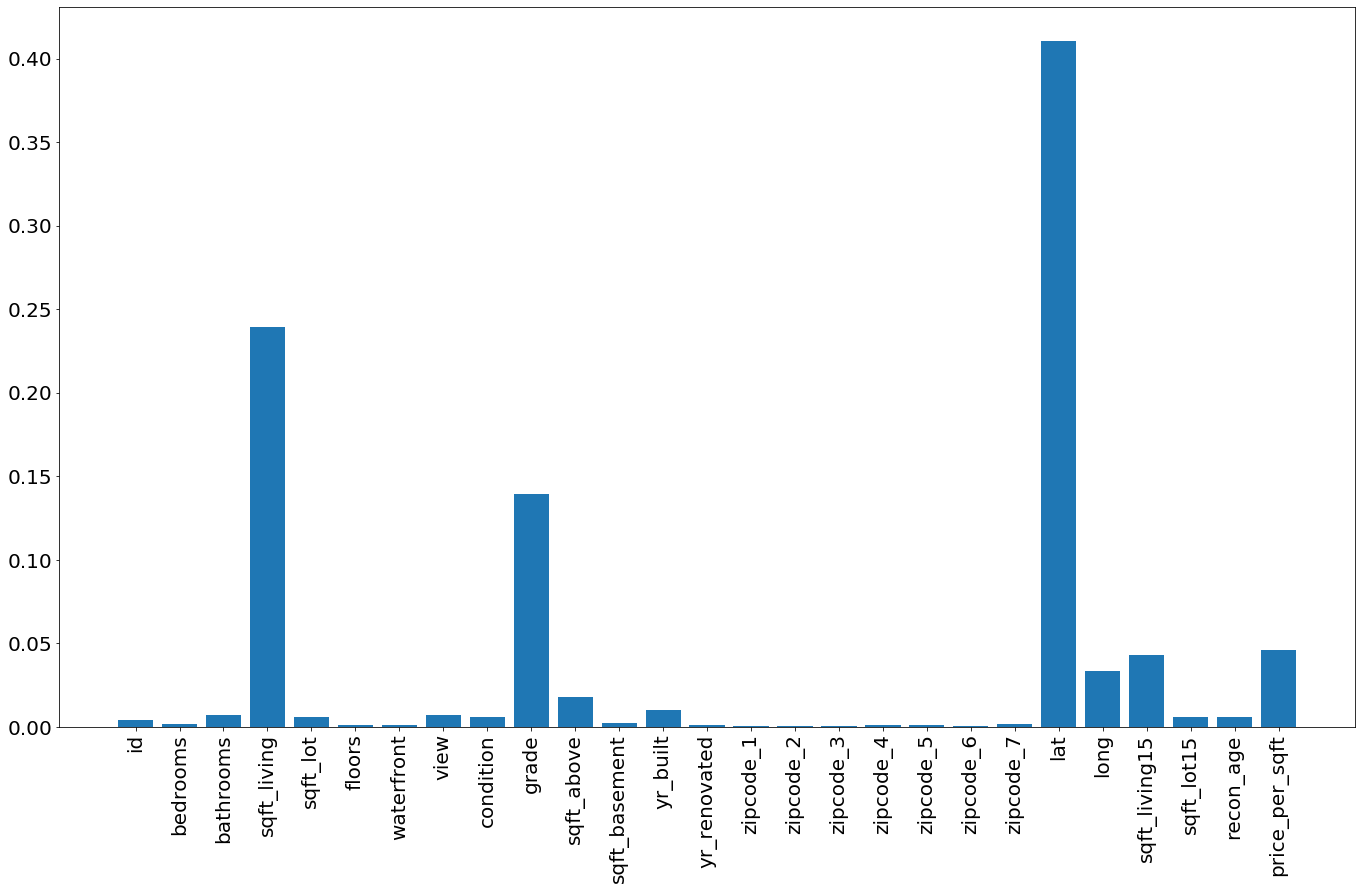

In [38]:
fig = plt.figure(figsize=(18,10))
ax = fig.add_axes([0,0,1,1])
attributes = list(X_train.columns)
plt.xticks(rotation=90, fontsize=20)
plt.yticks(fontsize=20)
importances = reg_rf.feature_importances_
ax.bar(attributes,importances)
plt.show()

Z grafu vyplýa, že najdôležitejšie atribúty pri určovaní ceny pomocou náhodného lesu sú sqft_living, grade a lat. Žiadne iné atribúty nedosiahli importance aspoň 0.1